In [9]:
#setting up
%run import-xgboost.py #calls script to build xgboost path variables for windows on my machine

#libraries used
import xgboost as xgb #modeling
import pandas as pd #dataframe manipulation
import numpy as np  #n-arrays
from sklearn.metrics import accuracy_score #scoring

import matplotlib.pyplot as plt #plotting graphs
import seaborn as sns  #for better looking graphs

%matplotlib inline

np.random.seed(0) #For repeatability of the experiment

target = 'survival_7_years'
idcolumn = 'id'

In [10]:
#Read the training data
df_train= pd.read_csv('training_data.csv', delimiter=",", header=0)
df_train.set_index("id", inplace=True)
#view the data
print(df_train.shape)
display(df_train.head(20))


(15385, 32)


,diagnosis_date,gleason_score,t_score,n_score,m_score,stage,age,race,height,weight,...,symptoms,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,survival_7_years
id,,,,,,,,,,,,,,,,,,,,,
1,Jun-05,4.0,T1c,N0,M0,I,86.0,4.0,66.0,158.0,...,U03,0,0,1,1,0,1,1,1,0
2,Feb-06,8.0,T3a,N1,M0,IV,66.0,2.0,70.0,174.0,...,"U06,S07",1,1,1,0,0,0,1,1,0
3,Mar-06,9.0,T1a,N0,M0,IIB,84.0,4.0,69.0,NaN,...,"U01,U02,U03,S10",1,1,0,0,1,1,1,1,1
4,Feb-05,8.0,T2b,N0,M0,IIB,86.0,3.0,69.0,173.0,...,"U01,U02,S10,O11",0,0,0,1,0,1,1,0,0
5,Dec-01,8.0,T4,N0,M0,IV,78.0,4.0,70.0,201.0,...,"U01,U03,U05,S07",1,1,1,0,0,0,1,1,0
6,Jul-01,3.0,T1a,N0,M0,IIA,75.0,4.0,69.0,166.0,...,"U02,U03,S10",0,0,0,0,1,0,0,1,1
7,Oct-05,8.0,T1b,N0,M0,IIB,85.0,4.0,67.0,166.0,...,"U01,U02,U03,S07",1,0,0,1,1,0,1,1,0
8,Dec-05,8.0,T4,N0,M0,IV,78.0,4.0,70.0,157.0,...,"U01,U02,U03",1,0,1,0,0,0,1,1,0
9,Jan-04,6.0,T3b,N0,M0,III,75.0,1.0,69.0,NaN,...,"U02,U03,O11",1,1,0,0,0,0,1,1,1


First, I did same basic sanity checks <br/> 
1) Is the data imbalanced? <br/>
2) Is the target variable - 7 year survival flag- correctly captured?

In [11]:
#Checking class imbalance
a = (df_train['survival_7_years']==1).sum()
print("Percentage of patients who survived after 7 years  %.2f%%" 
      % (a*100/df_train.shape[0]) )

Percentage of patients who survived after 7 years  43.23%


In [12]:
#Is the target variable - 7 year survival flag- correctly captured?
#for those patients where survival_1_year = 0, survivaly_7_years should also be 0!
np.where((df_train['survival_1_year'] == 0) & (df_train['survival_7_years'] ==1)
                     , 1, 0).sum()

0

The data is not imbalanced,and the 7 year survival aligns with 1 year survival in the training set. Next, I look at the train and test set individually.

In [13]:
#Read the test data
df_tst= pd.read_csv('richa_score.csv', delimiter=",", header=0)
df_tst.set_index("id", inplace=True)
#view the data
print(df_tst.shape)
display(df_tst.head(20))


(11531, 32)


,diagnosis_date,gleason_score,t_score,n_score,m_score,stage,age,race,height,weight,...,symptoms,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,survival_7_years
id,,,,,,,,,,,,,,,,,,,,,
20001,Oct-05,8.0,T3b,N0,M0,III,79.0,4.0,68.0,167.0,...,"U01,U02,S10",1,1,1,0,0,0,1,NaN,NaN
20002,Jun-02,10.0,T2c,N0,M0,IIB,84.0,2.0,70.0,169.0,...,"U01,U02,S07",1,0,0,1,0,0,1,NaN,NaN
20003,Mar-04,6.0,T4,N0,M0,IV,NaN,4.0,68.0,160.0,...,"U06,S07,O11",0,0,1,1,0,0,1,NaN,NaN
20004,Oct-03,7.0,T4,N1,M1a,IV,73.0,4.0,69.0,164.0,...,"S07,P03",1,0,1,0,1,0,1,0.0,NaN
20005,Mar-06,6.0,T1b,N0,M0,IIA,81.0,1.0,69.0,NaN,...,"U01,U03,U06,O11",0,0,1,1,0,0,1,NaN,NaN
20006,Apr-04,6.0,T4,N1,M0,IV,90.0,4.0,69.0,165.0,...,"U06,S07,S04",0,0,1,0,1,0,1,NaN,NaN
20007,Nov-00,9.0,T2c,N0,M0,IIB,63.0,3.0,70.0,NaN,...,"U01,U02,S04",0,0,0,1,0,0,0,NaN,NaN
20008,Jun-04,7.0,T4,N0,M0,IV,76.0,4.0,70.0,194.0,...,"U01,U03",0,0,1,0,1,0,1,1.0,NaN
20009,Feb-06,5.0,T3c,N0,M0,III,77.0,1.0,71.0,184.0,...,"U02,U03",0,0,1,0,0,0,0,1.0,NaN


In order to decide on whether to keep gleason,t,n,m score features in my analysis, I check for missing 'stage' values in both data sets

In [14]:
#check if stage information is missing for any patient in train and test

print(df_train['stage'].isnull().sum(), df_tst['stage'].isnull().sum())


0 0


Since no stage values are missing in either test or train sets, we can drop the gleason,t,n & m scores which are used to calculate the stage. 

In [15]:
#Choosing only relevant variables
cols_to_keep = ['stage','age' , 'height','weight','previous_cancer','smoker','side',
                'tumor_diagnosis','tumor_6_months','tumor_1_year','psa_diagnosis','psa_6_months', 'psa_1_year','tea',
                'rd_thrpy','h_thrpy','chm_thrpy','cry_thrpy','brch_thrpy','rad_rem','survival_1_year','survival_7_years']
#build the training and test set from the relevant variables
train = df_train[cols_to_keep].copy()
test = df_tst[cols_to_keep].copy()

#Combining train and test data sets to impute missing values
combined_set = pd.concat([train, test], axis = 0) # Stacks them vertically
display(combined_set.head(20))

print("Training Dataset has {} data points and {} features".format(*train.shape))
print("Test Dataset has {} data points and {} features".format(*test.shape))
print("Combined, the entire dataset has {} data points and {} features".format(*combined_set.shape))


,stage,age,height,weight,previous_cancer,smoker,side,tumor_diagnosis,tumor_6_months,tumor_1_year,...,psa_1_year,tea,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,survival_1_year,survival_7_years
id,,,,,,,,,,,,,,,,,,,,,
1,I,86.0,66.0,158.0,0.0,0.0,both,70.0,NaN,39.0,...,4.2,2.0,0,0,1,1,0,1,1.0,0.0
2,IV,66.0,70.0,174.0,0.0,1.0,both,43.0,28.0,16.0,...,7.5,4.0,1,1,1,0,0,0,1.0,0.0
3,IIB,84.0,69.0,NaN,0.0,0.0,right,51.0,NaN,89.0,...,18.5,0.0,1,1,0,0,1,1,1.0,1.0
4,IIB,86.0,69.0,173.0,0.0,0.0,right,104.0,NaN,NaN,...,NaN,2.0,0,0,0,1,0,1,0.0,0.0
5,IV,78.0,70.0,201.0,0.0,0.0,left,72.0,NaN,87.0,...,NaN,2.0,1,1,1,0,0,0,1.0,0.0
6,IIA,75.0,69.0,166.0,0.0,0.0,left,47.0,NaN,62.0,...,12.7,2.0,0,0,0,0,1,0,1.0,1.0
7,IIB,85.0,67.0,166.0,0.0,0.0,right,29.0,NaN,0.0,...,0.7,1.0,1,0,0,1,1,0,1.0,0.0
8,IV,78.0,70.0,157.0,NaN,NaN,right,85.0,NaN,42.0,...,NaN,NaN,1,0,1,0,0,0,1.0,0.0
9,III,75.0,69.0,NaN,1.0,0.0,left,51.0,NaN,3.0,...,9.3,4.0,1,1,0,0,0,0,1.0,1.0


Training Dataset has 15385 data points and 22 features
Test Dataset has 11531 data points and 22 features
Combined, the entire dataset has 26916 data points and 22 features


Next, I check for missing values

In [16]:
#test set
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11531 entries, 20001 to 31531
Data columns (total 22 columns):
stage               11531 non-null object
age                 10883 non-null float64
height              10488 non-null float64
weight              10490 non-null float64
previous_cancer     10360 non-null float64
smoker              10360 non-null float64
side                11531 non-null object
tumor_diagnosis     11321 non-null float64
tumor_6_months      3976 non-null float64
tumor_1_year        9927 non-null float64
psa_diagnosis       10502 non-null float64
psa_6_months        4385 non-null float64
psa_1_year          9616 non-null float64
tea                 10360 non-null float64
rd_thrpy            11531 non-null int64
h_thrpy             11531 non-null int64
chm_thrpy           11531 non-null int64
cry_thrpy           11531 non-null int64
brch_thrpy          11531 non-null int64
rad_rem             11531 non-null int64
survival_1_year     5818 non-null float64
sur

In [17]:
#test set
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15385 entries, 1 to 15385
Data columns (total 22 columns):
stage               15385 non-null object
age                 14637 non-null float64
height              14021 non-null float64
weight              14068 non-null float64
previous_cancer     13799 non-null float64
smoker              13799 non-null float64
side                15385 non-null object
tumor_diagnosis     15082 non-null float64
tumor_6_months      5322 non-null float64
tumor_1_year        13262 non-null float64
psa_diagnosis       13987 non-null float64
psa_6_months        5882 non-null float64
psa_1_year          12868 non-null float64
tea                 13799 non-null float64
rd_thrpy            15385 non-null int64
h_thrpy             15385 non-null int64
chm_thrpy           15385 non-null int64
cry_thrpy           15385 non-null int64
brch_thrpy          15385 non-null int64
rad_rem             15385 non-null int64
survival_1_year     15385 non-null int64
surviv

From the counts, we can see that there are missing values, even though they show up as non-null. 
From the view of the data above, we see missing values stored as NaN.
However instead of doing a blanket replace all on the missing values, I replace them strategically 
First I check if there are any rows with a large number of missing values in the train set, which can be dropped.

In [18]:
#Row-wise distribution of missing data in training set
display(train.isnull().sum(axis=1).nlargest(30)) #row wise nulls

id
2677     9
10832    9
11791    9
14597    9
542      8
802      8
1364     8
1472     8
2472     8
3387     8
3533     8
4322     8
4691     8
4783     8
5490     8
5532     8
7049     8
7708     8
8013     8
8668     8
8710     8
8744     8
9802     8
10057    8
12253    8
13191    8
13903    8
14273    8
14527    8
14659    8
dtype: int64

The maximum number of variables missing for a row is 9, for 4 rows. Since 9 doesn't seem a high enough number to warrant discarding the data, I decided to keep these rows. Test data cannot be discarded, so this check doesn't apply. <br\>
Next, we check for missing values per feature

In [19]:
#Variable-wise distribution of missing data in training set
display(train.isnull().sum(axis=0).nlargest(20)) #col wise null

tumor_6_months     10063
psa_6_months        9503
psa_1_year          2517
tumor_1_year        2123
previous_cancer     1586
smoker              1586
tea                 1586
psa_diagnosis       1398
height              1364
weight              1317
age                  748
tumor_diagnosis      303
stage                  0
side                   0
rd_thrpy               0
h_thrpy                0
chm_thrpy              0
cry_thrpy              0
brch_thrpy             0
rad_rem                0
dtype: int64

In [20]:
#Variable-wise distribution of missing data in test set
display(test.isnull().sum(axis=0).nlargest(20)) #col wise null

survival_7_years    11531
tumor_6_months       7555
psa_6_months         7146
survival_1_year      5713
psa_1_year           1915
tumor_1_year         1604
previous_cancer      1171
smoker               1171
tea                  1171
height               1043
weight               1041
psa_diagnosis        1029
age                   648
tumor_diagnosis       210
stage                   0
side                    0
rd_thrpy                0
h_thrpy                 0
chm_thrpy               0
cry_thrpy               0
dtype: int64

In [21]:
#Variable-wise distribution of missing data in combined set
display(combined_set.isnull().sum(axis=0).nlargest(20)) #col wise null

tumor_6_months      17618
psa_6_months        16649
survival_7_years    11531
survival_1_year      5713
psa_1_year           4432
tumor_1_year         3727
previous_cancer      2757
smoker               2757
tea                  2757
psa_diagnosis        2427
height               2407
weight               2358
age                  1396
tumor_diagnosis       513
stage                   0
side                    0
rd_thrpy                0
h_thrpy                 0
chm_thrpy               0
cry_thrpy               0
dtype: int64

We notice missing values in both train and test data, hence I impute them after combining. This prevents us from imputing incorrect central tendency values, in case their distribution is slightly different in the test and train sets. <br\>
<i> The treatment of each feature with respect to missing values is detailed in the attached report </i>

In [22]:
#Replacing NA for smoker, previous_cancer and tea variables with 0
combined_set['smoker'].fillna(0,inplace = True)
combined_set['previous_cancer'].fillna(0,inplace = True)
combined_set['tea'].fillna(0, inplace = True)

#Checking the replacement
print("Sum of missing values in smoker, previous_cancer and tea are %d , %d and %d respectively" 
      %(combined_set['smoker'].isnull().sum(),
         combined_set['previous_cancer'].isnull().sum(),
         combined_set['tea'].isnull().sum()))

Sum of missing values in smoker, previous_cancer and tea are 0 , 0 and 0 respectively


In [23]:
#Replacing NA for survival_1_year with 0 for missing values in test set
combined_set['survival_1_year'].fillna(0, inplace = True)
print("Sum of missing values in survival_1_yr in test set = %d" %combined_set['survival_1_year'].isnull().sum())

Sum of missing values in survival_1_yr in test set = 0


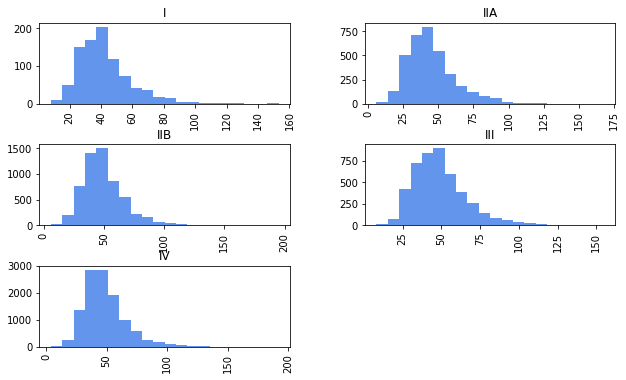

In [24]:
#Checking the distribution of tumor_diagnosis
combined_set.hist(column='tumor_diagnosis',by = 'stage',color="cornflowerblue",bins=20,figsize=[10,6])
plt.show()

We observe that the distribution of tumor_diagnosis for each stage has high-value outliers. Hence we impute missing values with median an not mean.

In [25]:
#check median tumor_diagnosis value for each stage
display(combined_set.groupby('stage', as_index=False)['tumor_diagnosis'].median())

,stage,tumor_diagnosis
0,I,39.0
1,IIA,42.0
2,IIB,47.0
3,III,46.0
4,IV,45.0


In [26]:
#replace the missing tumor size based on the stage of cancer
combined_set['tumor_diagnosis'].fillna(combined_set.groupby('stage')['tumor_diagnosis'].transform('median'), inplace=True)

#Check if the values are updated 
print("Sum of missing values in tumor_diagnosis = %d" %combined_set['tumor_diagnosis'].isnull().sum())

Sum of missing values in tumor_diagnosis = 0


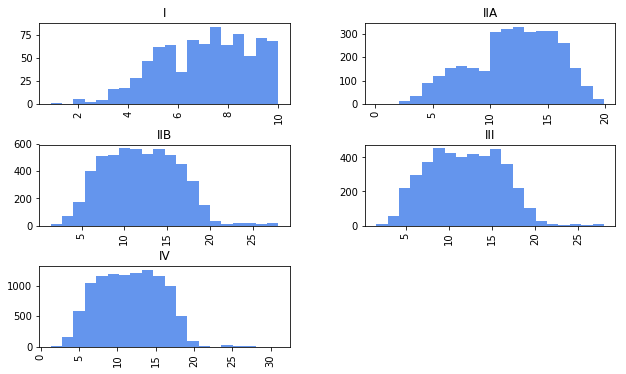

In [27]:
#Checking the distribution of psa_diagnosis
combined_set.hist(column='psa_diagnosis',by='stage',color="cornflowerblue",bins=20,figsize=[10,6])
plt.show()

We observe that the distributions of psa_diagnosis for each stage are highly skewed,with high-value outliers. Hence we impute missing values with median , not mean.

In [28]:
#check median psa_diagnosis value for each stage
display(combined_set.groupby('stage', as_index=False)['psa_diagnosis'].median())

,stage,psa_diagnosis
0,I,7.25
1,IIA,12.30
2,IIB,11.90
3,III,11.80
4,IV,11.60


In [29]:
#replace the missing tumor size based on the stage of cancer
combined_set['psa_diagnosis'].fillna(combined_set.groupby('stage')['psa_diagnosis'].transform('median'), inplace=True)

#Check if the values are updated 
print("Sum of missing values in psa_diagnosis = %d" % (combined_set['psa_diagnosis'].isnull().sum()))

Sum of missing values in psa_diagnosis = 0


Next we check the distributions for age, height and wieght and replace missing values accordingly

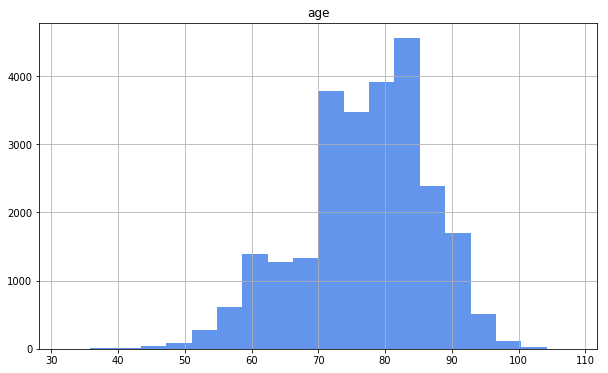

In [30]:
#Check distribution for age
combined_set.hist(column ='age',color="cornflowerblue",bins=20,figsize=[10,6])  
plt.show()

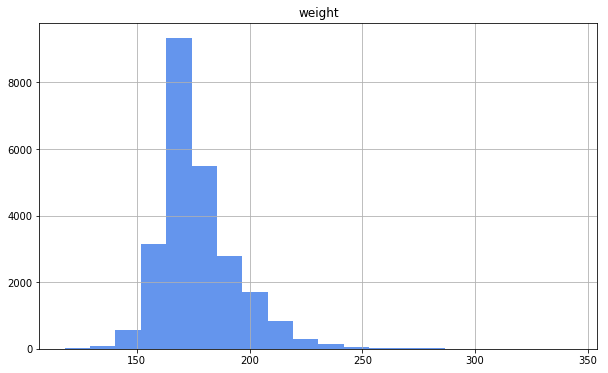

In [31]:
#Check distribution for weight
combined_set.hist(column ='weight',color="cornflowerblue",bins=20,figsize=[10,6])  
plt.show()

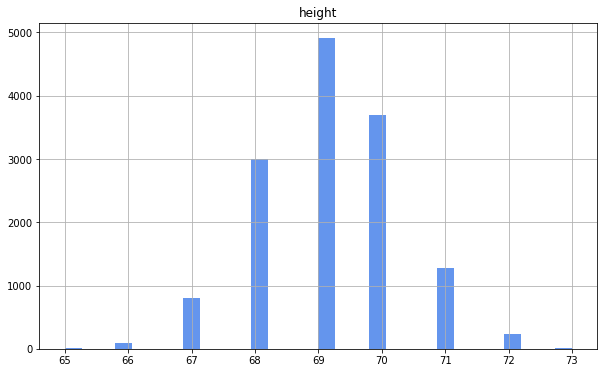

In [32]:
#Check distribution for height
train.hist(column ='height',color="cornflowerblue",bins=30,figsize=[10,6])
plt.show()

In [33]:

#replace age with mean age , since it seems to follow a normal distribution
combined_set['age'].fillna(combined_set['age'].mean(), inplace=True)
# #Check if the values are updated 
print("Sum of missing values in age = %d" % (combined_set['age'].isnull().sum()) )

#replace weight with median weight, since the distribution seems to be skewed and doesn't seem to be a Gaussian distribution
combined_set['weight'].fillna(combined_set['age'].mean(), inplace=True)
# #Check if the values are updated 
print("Sum of missing values in weight = %d" %(combined_set['weight'].isnull().sum()) )

#replace height with mean height, since the distribution seems to be a Gaussian distribution
combined_set['height'].fillna(combined_set['height'].mean(), inplace=True)
#Rounding the values
combined_set['height']=combined_set['height'].round()
#Check if the values are updated 
print("Sum of missing values in height = %d" %(combined_set['height'].isnull().sum()) )



Sum of missing values in age = 0
Sum of missing values in weight = 0
Sum of missing values in height = 0


Next, we tackle the features which give us information about the trend in recovery- <br/> 1 )tumor_diagnosis, tumor_6_months & tumor_1_year <br/> 2) psa_diagnosis, psa_6_months, psa_1_year <br/>
For both these sets, the 6 month variable has missing values for more than 60% of the patients! Hence instead of replacing the missing values, we disregard these and use only the 1 year variables.


In [34]:
#Check missing values in the 1 year variables
print("Sum of missing values in psa_1_year = %d" %(combined_set['psa_1_year'].isnull().sum()) )
print("Sum of missing values in tumor_1_year = %d" %(combined_set['tumor_1_year'].isnull().sum()) )

Sum of missing values in psa_1_year = 4432
Sum of missing values in tumor_1_year = 3727


In [35]:
#Check whether there are any patients for whom both 6mth and 1 year information is missing
print("# of patients for whom both 6mth and 1year information is missing for psa levels  = %d" 
      % np.where(combined_set['psa_1_year'].isnull()& combined_set['psa_6_months'].isnull()
                     , 1, 0).sum())
print("# of patients for whom both 6mth and 1year information is missing for tumor size  = %d" 
      % np.where(combined_set['tumor_1_year'].isnull()& combined_set['tumor_6_months'].isnull()
                     , 1, 0).sum())

# of patients for whom both 6mth and 1year information is missing for psa levels  = 2682
# of patients for whom both 6mth and 1year information is missing for tumor size  = 2425


By propagating 6 month values to 1 year variables, we can fill in - <br/> 1750 of the total 4432 missing values for psa levels and <br/> 1302 of the total 3727 missing values in tumor sizes.

In [36]:
#Fill missing 1 year values with 6 month values, wherever present
combined_set.loc[combined_set['psa_1_year'].isnull(),'psa_1_year'] = combined_set['psa_6_months']
combined_set.loc[combined_set['tumor_1_year'].isnull(),'tumor_1_year'] = combined_set['tumor_6_months']

In [37]:
#Check missing values in the 1 year variables after propagation
print("Sum of missing values in psa_1_year after replacement = %d" %(combined_set['psa_1_year'].isnull().sum()) )
print("Sum of missing values in tumor_1_year after replacement = %d" %(combined_set['tumor_1_year'].isnull().sum()) )

Sum of missing values in psa_1_year after replacement = 2682
Sum of missing values in tumor_1_year after replacement = 2425


After creating a new feature for trend, we replace the missing 2682 and 2452 values for psa level and tumor size respectively with a missing value flag. These missing values can be then handled by the model

In [38]:
# combined_set.drop(['psa_1yr_trend','tumor_1yr_trend'],axis=1)
# combined_set.shape
# combined_set.columns

In [39]:
#caluclate new feature 1_yr_trend for psa level and tumor respectively
combined_set['psa_1yr_trend']=combined_set['psa_diagnosis'] - combined_set['psa_1_year']
print("Sum of missing values in psa_1yr_trend = %d" %(combined_set['psa_1yr_trend'].isnull().sum()) )

Sum of missing values in psa_1yr_trend = 2682


In [40]:
combined_set['tumor_1yr_trend']=combined_set['tumor_diagnosis'] - combined_set['tumor_1_year']
print("Sum of missing values in tumor_1yr_trend = %d" %(combined_set['tumor_1yr_trend'].isnull().sum()) )

Sum of missing values in tumor_1yr_trend = 2425


In [41]:
#replace the missing values with a suitable missing value flag
#Check if -999 is a value in the set
np.where((combined_set['tumor_1yr_trend'] == -999) | (combined_set['psa_1yr_trend'] ==-999)
                     , 1, 0).sum()
#set missing values in 1 year trend variables with -999.0
combined_set['tumor_1yr_trend'].replace(np.nan,-999.0)
combined_set['psa_1yr_trend'].replace(np.nan,-999.0)

id
1          4.5
2          6.2
3         -2.5
4       -999.0
5       -999.0
6         -0.4
7          3.7
8       -999.0
9          6.9
10         1.4
11         3.9
12         7.7
13         2.8
14         0.3
15        -3.2
16         5.2
17         2.2
18         4.0
19         1.5
20         2.9
21      -999.0
22         2.8
23        -0.1
24        -0.2
25         6.0
26         2.2
27         7.2
28         2.7
29      -999.0
30        -2.2
         ...  
31502   -999.0
31503      1.6
31504   -999.0
31505      9.1
31506      0.3
31507     -2.0
31508      8.2
31509      3.0
31510      1.5
31511     11.1
31512      2.6
31513      4.5
31514      4.1
31515      4.8
31516      3.5
31517   -999.0
31518      5.5
31519      2.8
31520      5.8
31521     -1.1
31522      9.0
31523     -0.1
31524      3.2
31525      2.7
31526     -0.8
31527     -0.1
31528      5.3
31529      2.0
31530      3.6
31531     11.9
Name: psa_1yr_trend, Length: 26916, dtype: float64

In [42]:
#drop 6 mth, 1 year variables for tumor size and psa level
combined_set.drop(['psa_6_months','tumor_6_months','tumor_1_year','psa_1_year'],axis=1, inplace=True)
print("Combined dataset after data imputing has {} data points and {} features" .format(*combined_set.shape))

Combined dataset after data imputing has 26916 data points and 20 features


Next, we convert the two categorical variables - 'stage' and  'side' variable to numerical by using dummy encoding <br/>
For the stage columns, this creates four dummy variables, one for each stage -IIA,IIB,III,IV . Stage I is the reference variable
<br/>This creates two variables, side_left & side_right and drops the original side variable.
,with the reference category as 'both'

In [43]:
#For the stage variable, we use 'I' as the reference category to get 4 dummy columns
combined_set=pd.get_dummies(combined_set, columns =['stage'], drop_first=True )
#For the side variable,we use 'both' as the reference category to get two dummy columns 
combined_set=pd.get_dummies(combined_set, columns =['side'], drop_first=True )

In [44]:
print("Combined dataset after feature engineering has {} data points and {} features" .format(*combined_set.shape))

Combined dataset after feature engineering has 26916 data points and 24 features


In [45]:
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26916 entries, 1 to 31531
Data columns (total 24 columns):
age                 26916 non-null float64
height              26916 non-null float64
weight              26916 non-null float64
previous_cancer     26916 non-null float64
smoker              26916 non-null float64
tumor_diagnosis     26916 non-null float64
psa_diagnosis       26916 non-null float64
tea                 26916 non-null float64
rd_thrpy            26916 non-null int64
h_thrpy             26916 non-null int64
chm_thrpy           26916 non-null int64
cry_thrpy           26916 non-null int64
brch_thrpy          26916 non-null int64
rad_rem             26916 non-null int64
survival_1_year     26916 non-null float64
survival_7_years    15385 non-null float64
psa_1yr_trend       24234 non-null float64
tumor_1yr_trend     24491 non-null float64
stage_IIA           26916 non-null uint8
stage_IIB           26916 non-null uint8
stage_III           26916 non-null uint8
stage_

For xgboost, the model only takes in numerical features. Now that our dataset has only numerical variables, we can move on to modeling. <br/> We first split our combined set into train and test sets again. Since I did no reshuffling, they are vertically stacked and can be easily split. <br\> We should have <b> 15,385 training data entries and  11,531  test data entries.

In [46]:
#Split combined set in to train and test
final_train = combined_set[0:df_train.shape[0]] # Up to the last initial training set row
final_test = combined_set[df_train.shape[0]:] # Past the last initial training set row

In [47]:
print("Final Train set after feature engineering has {} data points and {} features" .format(*final_train.shape))
print("Final Train set after feature engineering has {} data points and {} features" .format(*final_test.shape))

Final Train set after feature engineering has 15385 data points and 24 features
Final Train set after feature engineering has 11531 data points and 24 features


In [48]:
final_train.head()

,age,height,weight,previous_cancer,smoker,tumor_diagnosis,psa_diagnosis,tea,rd_thrpy,h_thrpy,...,survival_1_year,survival_7_years,psa_1yr_trend,tumor_1yr_trend,stage_IIA,stage_IIB,stage_III,stage_IV,side_left,side_right
id,,,,,,,,,,,,,,,,,,,,,
1,86.0,66.0,158.000000,0.0,0.0,70.0,8.7,2.0,0,0,...,1.0,0.0,4.5,31.0,0,0,0,0,0,0
2,66.0,70.0,174.000000,0.0,1.0,43.0,13.7,4.0,1,1,...,1.0,0.0,6.2,27.0,0,0,0,1,0,0
3,84.0,69.0,76.872375,0.0,0.0,51.0,16.0,0.0,1,1,...,1.0,1.0,-2.5,-38.0,0,1,0,0,0,1
4,86.0,69.0,173.000000,0.0,0.0,104.0,11.9,2.0,0,0,...,0.0,0.0,NaN,NaN,0,1,0,0,0,1
5,78.0,70.0,201.000000,0.0,0.0,72.0,18.1,2.0,1,1,...,1.0,0.0,NaN,-15.0,0,0,0,1,1,0


In [49]:
final_test.head()

,age,height,weight,previous_cancer,smoker,tumor_diagnosis,psa_diagnosis,tea,rd_thrpy,h_thrpy,...,survival_1_year,survival_7_years,psa_1yr_trend,tumor_1yr_trend,stage_IIA,stage_IIB,stage_III,stage_IV,side_left,side_right
id,,,,,,,,,,,,,,,,,,,,,
20001,79.000000,68.0,167.000000,0.0,0.0,44.0,11.8,0.0,1,1,...,0.0,NaN,3.3,-5.0,0,0,1,0,0,0
20002,84.000000,70.0,169.000000,0.0,0.0,93.0,7.0,2.0,1,0,...,0.0,NaN,-1.2,-16.0,0,1,0,0,0,0
20003,76.872375,68.0,160.000000,0.0,0.0,35.0,9.6,4.0,0,0,...,0.0,NaN,3.3,11.0,0,0,0,1,0,0
20004,73.000000,69.0,164.000000,0.0,0.0,40.0,5.3,1.0,1,0,...,0.0,NaN,NaN,NaN,0,0,0,1,1,0
20005,81.000000,69.0,76.872375,0.0,0.0,53.0,10.0,1.0,0,0,...,0.0,NaN,5.8,22.0,1,0,0,0,1,0


In [50]:
#set the final list of features
cols_to_use = ['age', 'height', 'weight', 'previous_cancer', 'smoker',
       'tumor_diagnosis', 'psa_diagnosis', 'tea', 'rd_thrpy', 'h_thrpy',
       'chm_thrpy', 'cry_thrpy', 'brch_thrpy', 'rad_rem', 'survival_1_year','psa_1yr_trend', 'tumor_1yr_trend', 'stage_IIA',
       'stage_IIB', 'stage_III', 'stage_IV', 'side_left', 'side_right']


With the data all set up, we move on to the modelling. I used gradient boosting, using the xgboost package. <br/>
Since the focus here is not primarily on model accuracy, I hand-tuned parameters to improve the performance, instead of simply running a GridSearch.

In [51]:
#building and tuning the Xgboost model
from sklearn.metrics import confusion_matrix

#Creating the DMatrix from the training data set
xgtrain = xgb.DMatrix(final_train[cols_to_use], label=final_train[target])

#Setting the hyper-parameters for the model
cv_folds =5 
early_stopping_rounds = 50

#initial model- started with a high variance 
xgb1 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=100,
 max_depth=10,
 subsample=0.9,
 seed=1)

#Decreasing subsample and max_depth to reduce overfit
xgb2 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=100, 
 max_depth=8,
 subsample=0.8,
 seed=1)

#Decreasing subsample and max_depth to further reduce overfit
xgb3 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=100,
 max_depth=6,
 subsample=0.6,
 seed=1)

#inititalize the model for cross validation
xgbmodel=xgb3
#perform cross validation 
cvresult = xgb.cv(xgbmodel.get_xgb_params(), xgtrain, num_boost_round=xgbmodel.get_params()['n_estimators'], nfold=cv_folds,
                      metrics = ['error'], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
xgbmodel.set_params(n_estimators=cvresult.shape[0]) 
best_round = cvresult.shape[0] -1
print(cvresult.tail())


    test-error-mean  test-error-std  train-error-mean  train-error-std
32         0.341372        0.007914          0.323286         0.001566
33         0.341047        0.007828          0.323156         0.001760
34         0.341307        0.008122          0.323334         0.001432
35         0.340787        0.008300          0.323334         0.001108
36         0.340722        0.008130          0.323480         0.001301


In [52]:
#Evaluating the model 
#Fit the selected model on the training data
xgbmodel.fit(final_train[cols_to_use], final_train[target],eval_metric="error")

#Predict the dependent variable
y_pred = xgbmodel.predict(final_train[cols_to_use])
class_predictions = [round(value) for value in y_pred] #use default threhold of 0.5

#Print model accuracy
print ( "Train Accuracy : %.4f" % accuracy_score(final_train[target], class_predictions))        

Train Accuracy : 0.6753


In [53]:
#Check the confusion matrix
from sklearn.metrics import classification_report
print(classification_report(final_train[target], class_predictions) )

             precision    recall  f1-score   support

        0.0       0.72      0.71      0.71      8734
        1.0       0.62      0.63      0.63      6651

avg / total       0.68      0.68      0.68     15385



We observe a ~68% accuracy! That is much better than our 53% baseline! <br/>  Let's look at the feature importances before we predict the survival values on the scoring data

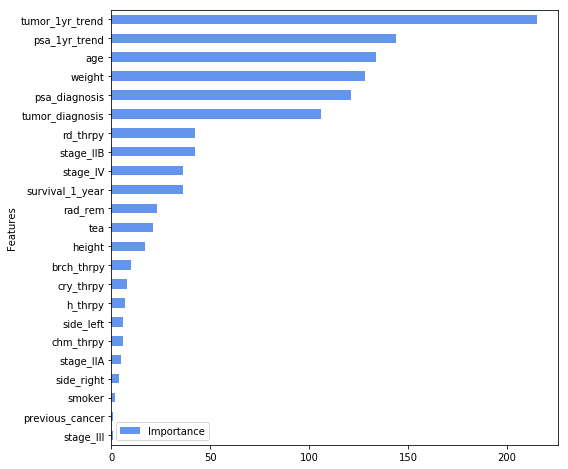

In [54]:
#Feature importance 
best_model = xgb.train(xgb3.get_xgb_params(), xgtrain, best_round)
importances = best_model.get_fscore()
imp_frame = pd.DataFrame({'Importance': list(importances.values()), 'Features': list(importances.keys())})
imp_frame.sort_values(by = 'Importance', inplace = True)
imp_frame.plot(kind = 'barh', x = 'Features', figsize = (8,8), color = 'cornflowerblue')
plt.show()

As we see from the variable importance graph, the 1 year trend variables that we created, for change in tumor size and psa levels are both extremely useful for the model!<br/>
In addition, the age and wieght of the patient are also used.
Next, we use the model to predict the labels in the scoring data

In [1]:
#Predict the dependent variable
xgtest = xgb.DMatrix(final_test[cols_to_use])
test_y_pred = best_model.predict(xgtest) # Predict using our test data
test_class_predictions = [round(value) for value in test_y_pred] #use default threhold of 0.5
#building empty data frame with test set id's
test_y = pd.DataFrame(index=final_test.index)
#populating the predictions
test_y[target]=test_class_predictions

#updating original test data set with predicted values
df_tst.update(test_y)
#checking the update
df_tst.shape

np.where((df_tst['survival_1_year'] == 0) & (df_tst['survival_7_years'] ==1)
                     , 1, 0).sum()

#Saving the test data set to csv
df_tst.to_csv('RichaGupta_score.csv',sep=",")

NameError: name 'xgb' is not defined